In [29]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd

device = th.device("cuda" if th.cuda.is_available() else "cpu")
device = th.device("cpu")
print(f"Using device {device}")

Using device cpu


In [30]:
hyperparams = {
    "learning_rate": 2e-4,
    "batch_size": 64,
    "epochs": 150,
    "l1_lambda": 100,
    "adam_betas": (0.5, 0.999), # default values are (0.9, 0.999)
}

# Dataset

## Preparing the dataset

In [31]:
def load_train_test_image_pairs(dataset_path, dataset_name):
    pass

def load_validation_images(dataset_path, dataset_name):
    pass

transforms = [
    T.Resize([256, 256], interpolation=T.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomCrop(256),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #TOOD: Make sure this places values in [-1,1]
]

def prep_images():
    
    training_set = th.utils.data.Dataset()
    test_set = th.utils.data.Dataset()
    validation_set = th.utils.data.Dataset()
    
    return training_set, test_set, validation_set



## Running dataset construction code

In [32]:
training_set, test_set, validation_set = prep_images()

training_set = th.utils.data.DataLoader(
    dataset=training_set,
    batch_size=hyperparams['batch_size']
    )

test_set = th.utils.data.DataLoader(
    dataset=test_set,
    batch_size=hyperparams['batch_size']
    )

validation_set = th.utils.data.DataLoader(
    dataset=validation_set,
    batch_size=hyperparams['batch_size']
    )

# Models

## Discriminator

In [33]:
class DownModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      
    
class ZeroPadModule(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=0)
        return x

class Discriminator(nn.Module):
    
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG
        
        self.DownLayers = nn.Sequential(
            DownModule(6, 64),
            DownModule(64, 128),
            DownModule(128, 256),
            ZeroPadModule(),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ZeroPadModule(),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() #NOTE: Not actually in the paper, but required for the BCELoss (limits values to [0,1])
        )
        
    def forward(self, x: th.Tensor, y: th.Tensor) -> th.Tensor:
        """Forward pass of the discriminator

        Args:
            x (th.Tensor): Raw underwater image
            y (th.Tensor): Enhanced underwater image

        Returns:
            th.Tensor: Output tensor measuring the realness of the input images
        """
        
        z = th.concatenate((x, y), dim=1)
        
        # Input tensor shape
        if self.DEBUG:
            print("Input tensor shape:")
            print(z.shape)
        
        # TODO: Convolutions
        
        for layer in self.DownLayers:
            z = layer(z)
            if self.DEBUG:
                print(z.shape)
        
        return z
    
#discriminator = Discriminator(DEBUG=True).to(device)

#ample = th.randn(1, 3, 256, 256, device=device)
#clone = sample.clone()
#output = discriminator(sample, clone)

## Generator / Autoencoder

In [34]:
class EncoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      

class FeatureMapModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        return x      

class DecoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x
    
class OutputModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = self.deconv(x)
        return x

class Autoencoder(nn.Module):
    """
    Autoencoder model for image generation

    A residual autoencoder model for image generation. 
    The final model will be an image-to-image translation model
    that enhances underwater images.
    """
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG

        self.EncoderLayers = nn.ModuleList([
            EncoderModule(3, 64),
            EncoderModule(64, 128),
            EncoderModule(128, 256),
            EncoderModule(256, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            FeatureMapModule(512, 512),
        ])
        
        self.DecoderLayers = nn.ModuleList([
            DecoderModule(512, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512, dropout_prob=0.0),
            DecoderModule(1024, 256, dropout_prob=0.0),
            DecoderModule(512, 128, dropout_prob=0.0),
            DecoderModule(256, 64, dropout_prob=0.0),
        ])
        
        self.OutputLayer = OutputModule(128, 3)
        self.sigmoid = nn.Sigmoid() #NOTE: Not actually in the paper, but required to limit values to [0,1]

        
    def forward(self, x, z):
        """Forward pass for the autoencoder model.

        Args:
            x (th.Tensor): Input image tensor
            z (th.Tensor): Noise tensor

        Returns:
            th.Tensor: Output image tensor
        """

        #TODO: Figure out precisely how the noise tensor is used. Tentaively we add them together.
        x = x + z

        # Store the activations of the encoder layers for skip connections
        layer_outputs = []
        
        if self.DEBUG:
            print("Starting forward pass")
            print(x.shape)
        
        # Encoder pass
        for i in range(len(self.EncoderLayers)):
            x = self.EncoderLayers[i](x)
            if i < len(self.EncoderLayers) - 1:
                layer_outputs.append(x)
            if self.DEBUG:
                print(x.shape)
        
        if self.DEBUG:
            print("Encoding complete")
            print(x.shape)
        
        
        #[print("Stored activations: ",x.shape) for x in layer_outputs]
        
        # Decoder pass      
        for i in range(len(self.DecoderLayers)):
            
            if i != 0:
                # Get the appropriate encoder activation
                s = layer_outputs.pop()
                
                # If the shapes match, concatenate the activations
                if x.shape == s.shape:
                    x = th.cat((x, s), 1)
                    
                else:
                    print("Error, shapes do not match")
                    print("X:", x.shape)
                    print("S:", s.shape)
                    return th.tensor([])

            # Pass the concatenated activations through the decoder layer
            x = self.DecoderLayers[i](x)
            if self.DEBUG:
                print(x.shape)
                 
        if self.DEBUG:
            print("Decoding complete")
        
        # Perform the final deconvolution
        x = th.cat((x, layer_outputs.pop()), 1)
        x = self.OutputLayer(x)
        x = self.sigmoid(x)
        
        if self.DEBUG:
            print("Is layer_outputs empty:", len(layer_outputs) == 0)
            print(x.shape)
            print("Output complete")
            
        return x
 
#generator = Autoencoder(DEBUG=True).to(device)

#sample = th.randn(1, 3, 256, 256, device=device)
#noise = th.randn(1, 3, 256, 256, device=device)
#output = generator(sample, noise)

# Training Loop

## Defining the loop

In [35]:
def train_loop(dataloader, discriminator, generator, d_optimizer, g_optimizer, device, epochs=150, l1_lambda=100):
    
    loss_stats = pd.DataFrame(columns=["Epoch","d_loss", "g_loss", "g_GAN_loss", "g_L1_loss"])
    
    # Define the loss functions
    d_real_loss = th.nn.BCELoss()
    d_gan_loss = th.nn.BCELoss()
    g_gan_loss = th.nn.BCELoss()
    g_l1_loss = th.nn.L1Loss()
            
    for epoch in range(epochs):

        for batch, (x, y) in enumerate(dataloader):
                
            x, y = x.to(device), y.to(device)
            
            #========================#
            # Discriminator training #
            #========================#
            
            # Zero the parameter gradients
            d_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, y).detach()
            d_real = discriminator(x, y)
            d_fake = discriminator(x, z)
            
            # Compute the loss
            drl = d_real_loss(d_real, th.ones_like(d_real))
            dgl = d_gan_loss(d_fake, th.zeros_like(d_fake))
            
            d_loss = drl + dgl
            
            # Backward pass
            d_loss.backward()
            
            # Update weights
            d_optimizer.step()
            
            #====================#
            # Generator training #
            #====================#
            
            # Zero the parameter gradients
            g_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, y)
            d_fake = discriminator(x, z).detach()
            
            # Compute the loss
            ggl = g_gan_loss(d_fake, th.ones_like(d_fake))
            gl1 = g_l1_loss(z, y)
            
            g_loss = ggl + l1_lambda * gl1
            
            # Backward pass
            g_loss.backward()
            
            # Update weights
            g_optimizer.step()
            
            # Print statistics
            #TODO: Print the loss statistics at the end of each epoch
            if batch % len(dataloader) == 0:
                # Clear the output
                from IPython.display import clear_output
                clear_output(wait=True)
                print(f"Epoch {epoch}, batch {batch}, d_loss: {d_loss.item():.2f}, g_loss: {g_loss.item():.2f}")
                
            # Save the loss statistics
            loss_stats = pd.concat(
                [loss_stats, pd.DataFrame(
                    {
                    "Epoch": epoch,
                    "d_loss": d_loss.item(), 
                    "g_loss": g_loss.item(), 
                    "g_GAN_loss": ggl.item(), 
                    "g_L1_loss": gl1.item()
                    }, index=[0])
                 ]
                )

        #display(loss_stats.head())
        
        
    return loss_stats

## Random noise to test loop

In [36]:
# Generate 2 batches of random images of dimensions (3, 256, 256)
size = 10
batch1 = th.rand(size, 3, 256, 256, device=device)
batch2 = th.rand(size, 3, 256, 256, device=device)

# Create a dataloader
dataloader = th.utils.data.DataLoader(th.utils.data.TensorDataset(batch1, batch2), batch_size=hyperparams["batch_size"])

# Sample a batch from the dataloader
#sample = next(iter(dataloader))

# Display the shape of the sample
#print(sample[0].shape, sample[1].shape)

## Running the loop

Description of various GAN training problems: 
- https://developers.google.com/machine-learning/gan/problems
- https://arxiv.org/pdf/2005.00065.pdf

In [37]:
train_set = dataloader

generator = Autoencoder().to(device)
discriminator = Discriminator().to(device)

d_optimizer = optim.Adam(
    discriminator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=True,
)

g_optimizer = optim.Adam(
    generator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=False,
)

loss_stats = train_loop(
    train_set, 
    discriminator, 
    generator, 
    d_optimizer, 
    g_optimizer, 
    device, 
    epochs=20,#hyperparams["epochs"], 
    l1_lambda=hyperparams["l1_lambda"]
    )

display(loss_stats)

Epoch 19, batch 0, d_loss: 49.24, g_loss: 22.21


,Epoch,d_loss,g_loss,g_GAN_loss,g_L1_loss
0,0,1.422022,31.722500,0.473662,0.312488
0,1,1.554565,30.637827,0.306210,0.303316
0,2,1.841990,29.727850,0.184724,0.295431
0,3,2.336237,28.912153,0.114590,0.287976
0,4,3.022243,28.199804,0.084427,0.281154
0,5,3.855432,27.588858,0.083773,0.275051
0,6,4.730021,27.060118,0.106009,0.269541
0,7,5.590109,26.532724,0.151136,0.263816
0,8,6.864130,26.051432,0.219140,0.258323
0,9,9.835390,25.669821,0.297730,0.253721


### Plotting traing results

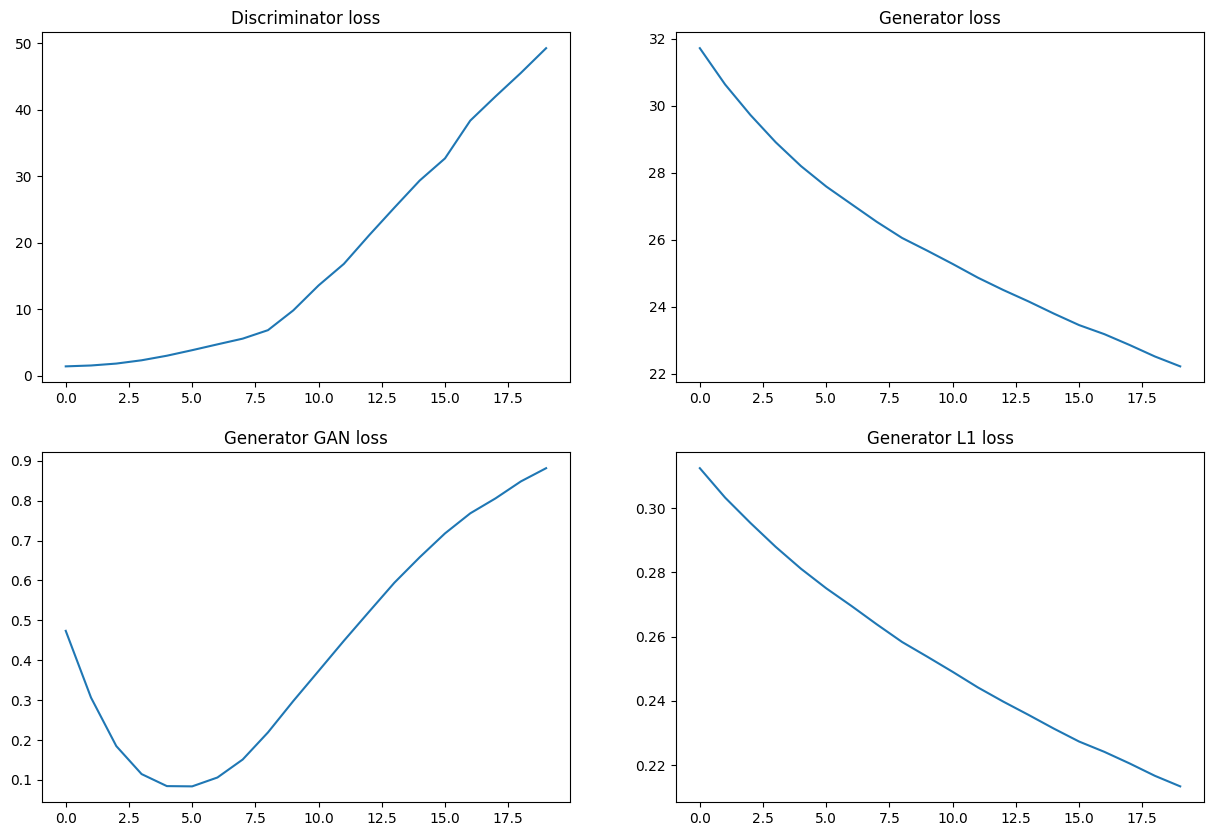

In [38]:
# Plot the loss statistics on different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(loss_stats["Epoch"], loss_stats["d_loss"])
axs[0, 0].set_title("Discriminator loss")
axs[0, 1].plot(loss_stats["Epoch"], loss_stats["g_loss"])
axs[0, 1].set_title("Generator loss")
axs[1, 0].plot(loss_stats["Epoch"], loss_stats["g_GAN_loss"])
axs[1, 0].set_title("Generator GAN loss")
axs[1, 1].plot(loss_stats["Epoch"], loss_stats["g_L1_loss"])
axs[1, 1].set_title("Generator L1 loss")
plt.show()


### Testing image generation

tensor(1.0000) tensor(1.0000)
tensor(0.9928, grad_fn=<MaxBackward1>)


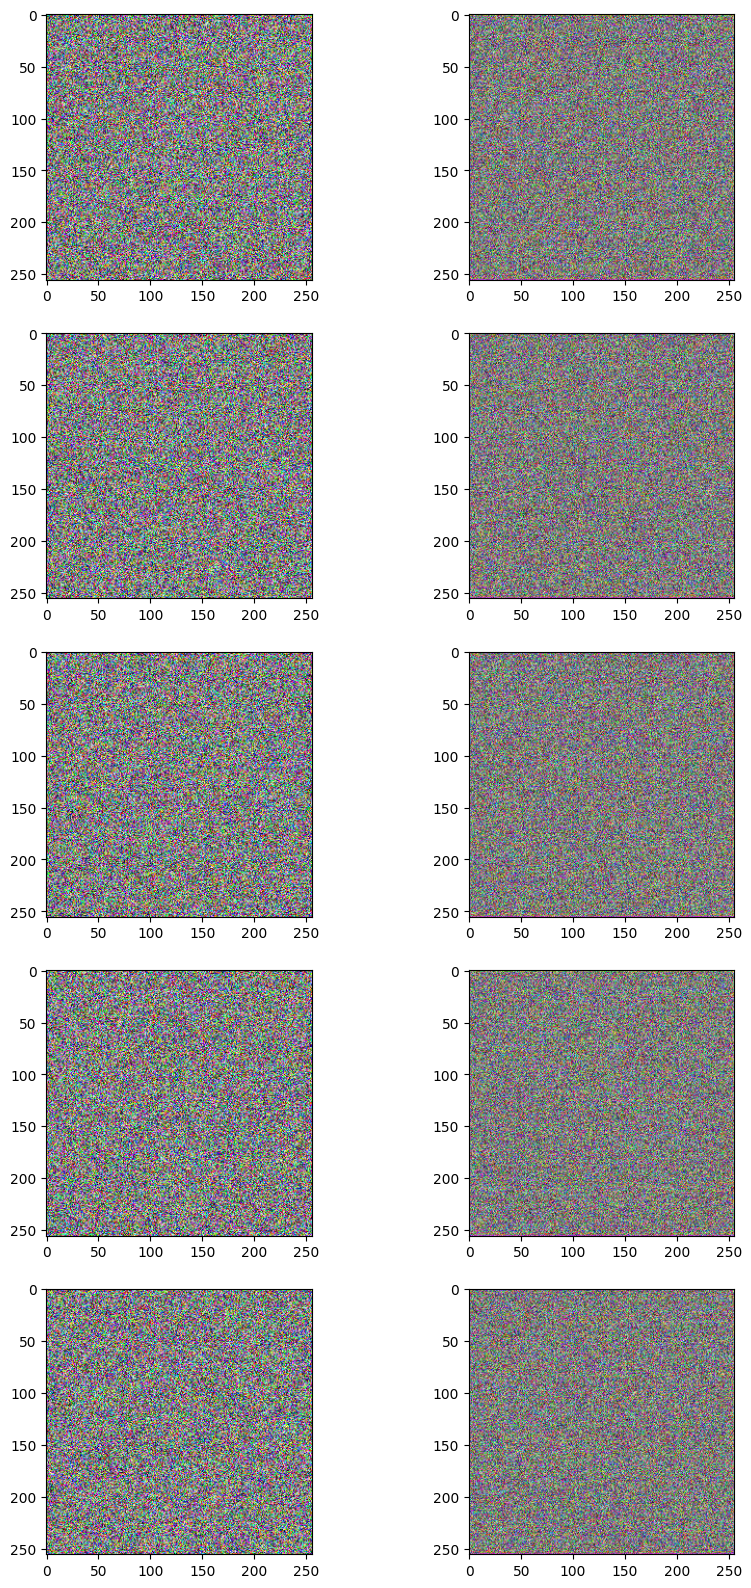

In [39]:
# Generate 10 random images using 2 noise tensors
noise1 = th.rand(10, 3, 256, 256, device=device)
noise2 = th.rand(10, 3, 256, 256, device=device)

# Print the max value of the noise tensors
print(noise1.max(), noise2.max())

# Generate 10 enhanced images
enhanced_images = generator(batch1, noise1)

# Print the max value of the enhanced images
print(enhanced_images.max())

# Plot the original and enhanced images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axs[i, 0].imshow(noise1[i].permute(1, 2, 0).cpu().detach().numpy())
    axs[i, 1].imshow(enhanced_images[i].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

# Model evaluation

## Defining the metrics

In [40]:
def PSNR(x, y):
    # Maximum possible pixel value
    MAX = 1.0
    return 10 * np.log10(MAX / np.mean((x - y) ** 2))

def SSIM(x, y):
    # Maximum possible pixel value
    L = 1.0
    
    # Constants
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
    
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    sigma_x = np.mean((x - mu_x) ** 2)
    sigma_y = np.mean((y - mu_y) ** 2)
    
    sigma_xy = np.mean((x - mu_x) * (y - mu_y))
    
    num = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    den = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    
    return np.mean(num / den)

def UIQM(x):
    c1 = 0.0282
    c2 = 0.2953
    c3 = 3.5753
    
    #TODO: Implement the rest of the function
    UICM = 0
    UISM = 0
    UIConM = 0
    
    return c1 * UICM + c2 * UISM + c3 * UIConM

def get_metrics(test_data, generator):
    metrics = pd.DataFrame(columns=["PSNR", "SSIM", "UIQM"])
    
    #TODO: Limit the number of images to 500
    
    for i, (x, y) in enumerate(test_data):
        x = x.to(device)
        y = y.detach().numpy()
        
        noise = th.randn(x.shape, dtype=th.float32).to(device)
        
        enhanced = generator(x, noise).detach().numpy()
        
        psnr = PSNR(y, enhanced)
        ssim = SSIM(y, enhanced)
        uiqm = UIQM(enhanced)
        
        metrics.loc[i] = [psnr, ssim, uiqm]
        
    return metrics

## Getting the test metrics

In [41]:
#TODO: Replace the random noise with the actual test data
test_data = th.utils.data.DataLoader(th.utils.data.TensorDataset(batch1, batch2), batch_size=1)

raw_metrics = get_metrics(test_data, generator)

summary = pd.DataFrame(columns=["Mean", "Std"])

summary.loc["PSNR"] = [raw_metrics["PSNR"].mean(), raw_metrics["PSNR"].std()]
summary.loc["SSIM"] = [raw_metrics["SSIM"].mean(), raw_metrics["SSIM"].std()]
summary.loc["UIQM"] = [raw_metrics["UIQM"].mean(), raw_metrics["UIQM"].std()]

display(summary)

,Mean,Std
PSNR,8.947672,0.013197
SSIM,0.017300,0.002440
UIQM,0.000000,0.000000


# Saving the model

In [42]:
# Path to the model weights
path = "./rsc/model_weights/"
discriminator_path = path + "discriminator.pth"
generator_path = path + "generator.pth"

# Save model weights for discriminator and generator
th.save(discriminator.state_dict(), discriminator_path)
th.save(generator.state_dict(), generator_path)